In [28]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import urllib, json
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
!pip install networkx

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 12.9 MB/s eta 0:00:00


# Introduction to Networkx

The simple methods '.nodes()' and '.edges()' print the key components of the network.

In [4]:
HG = nx.house_graph()
HG.nodes()
HG.edges()

NodeView((0, 1, 2, 3, 4))

EdgeView([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)])

## Drawing the network

To draw the network, we need to give it a dictionary that maps each node to an X-Y coordinate. I give one below.

{0: Text(0, 0, '0'),
 1: Text(1, 0, '1'),
 2: Text(0, 1, '2'),
 3: Text(1, 1, '3'),
 4: Text(0.5, 2.0, '4')}

(np.float64(-0.10500000000000001),
 np.float64(1.105),
 np.float64(-0.21000000000000002),
 np.float64(2.21))

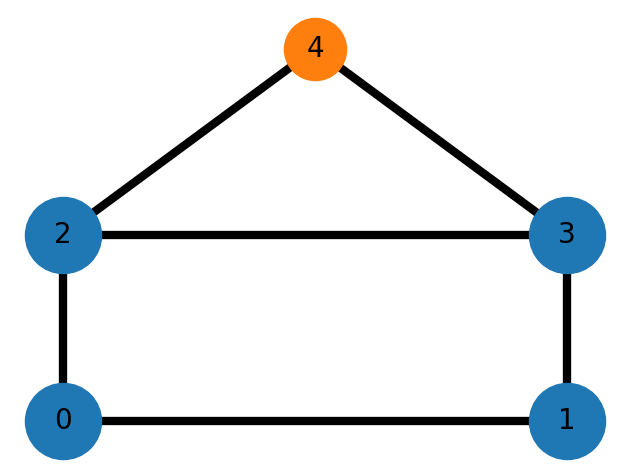

In [5]:
pos = {0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (0.5, 2.0)}

nx.draw_networkx_nodes(
    HG, pos, node_size=3000, nodelist=[0, 1, 2, 3], 
    node_color="tab:blue"
)

nx.draw_networkx_nodes(HG, pos, node_size=2000, 
                       nodelist=[4], node_color="tab:orange")

nx.draw_networkx_edges(HG, pos, alpha=1, width=6)
nx.draw_networkx_labels(HG, pos, font_size=20)
plt.tight_layout()
plt.axis("off")

In [7]:
ADJ = nx.to_pandas_adjacency(HG)
ADJ = ADJ.astype(bool)
ADJ

,0,1,2,3,4
0,False,True,True,False,False
1,True,False,False,True,False
2,True,False,False,True,True
3,False,True,True,False,True
4,False,False,True,True,False


In [8]:
deg_0 = nx.degree(HG, 0) 
deg_0

2

# Activity
We will learn how to process a dataframe into a useable edgelist to feed into a graph.

In [10]:
df = pd.read_pickle("../public_data/Raw_Tweets.pkl") # Load your tweets
df.head()
df.shape

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN
28315,1221213073652043776,14499829,Sat Jan 25 23:27:40 +0000 2020,en,WHO’s risk assessment of the new #coronavirus ...,original,1743,5196950,46697,[],NaN,NaN,NaN,NaN,NaN
6092,1222281847163576321,1135486501,Tue Jan 28 22:14:35 +0000 2020,en,#FYI: 50 million are under travel restrictions...,original,950,27025,11145,[9624742],NaN,NaN,NaN,NaN,NaN
13618,1222289121118511104,117793973,Tue Jan 28 22:43:30 +0000 2020,en,What should I do if I have traveled to China a...,original,1236,5860,4578,[],NaN,NaN,NaN,NaN,NaN
19205,1222285279047843843,1465196934,Tue Jan 28 22:28:14 +0000 2020,en,Disease outbreaks can result in misinformation...,original,1946,3581,4636,[],NaN,NaN,NaN,NaN,NaN


(59887, 15)

### 1.1 Subset the dataframe to network data

- First, using .value_counts(), identify how many types of tweets there are, using the tweet_type column. 
- Then, filter out all tweets that are not "retweeted_tweet_without_comment" and "quoted_tweet."

In [20]:
# your code here
#df.tweet_type.value_counts()
df = df[(df.tweet_type == 'retweeted_tweet_without_comment') | (df.tweet_type == 'quoted_tweet')]

In [21]:
## Run this. Why is it empty?
df[(df.tweet_type == "retweeted_tweet_without_comment") & (df.tweet_type == "quoted_tweet")]

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid


### 1.2 Create an edgelist

The "userid" column shows the person that did the retweeting. Create a new column called "userid2" that denotes the user retweeted. You will need to use the columns "rt_userid" and "qtd_userid."

In [29]:
df['userid2'] = np.where(df['rt_userid'].notna(),
                        df['rt_userid'],
                        np.where(df['qtd_userid'].notna(),
                                 df['qtd_userid'],
                                 None))



### 1.3 Sentiment scoring. 
- Now, use SentimentIntensityAnalyzer to label the sentiment of the text, in a new column called "weight." 
- The subset the dataframe to only have "userid", "user2", and "weight". 
- Rename "userid" to "user1", then group by "user1" and "user2", to find the mean sentiment (mean weight).

You now have your first edgelist!

In [45]:
import nltk

In [46]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Justin\AppData\Roaming\nltk_data...


True

In [48]:
S = SentimentIntensityAnalyzer()
S.polarity_scores("sample text for labeling")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

# Netwulf Visualization
#### If you don't have the module, pip install netwulf
#### https://netwulf.readthedocs.io/en/latest/about.html

In [32]:
!pip install netwulf

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for netwulf: filename=netwulf-0.1.5-py3-none-any.whl size=238080 sha256=ef9d556c2033a399c36fd3b4ddd2dcb01c3f4518b76db636606e2a803b83659e
  Stored in directory: c:\users\justin\appdata\local\pip\cache\wheels\92\f6\e2\67af6930ec9e8b9d5f7f729567235079f1586bb336f722ce6e
Successfully built netwulf


In [33]:
EL =  pd.read_pickle("../public_data/edge_list_final2.pkl")

In [34]:
EL[["user1","user2"]].values

array([[ 426033838,  146569971],
       [ 418859255,  146569971],
       [ 418859255,  146569971],
       ...,
       [2953974395,    5558312],
       [2953974395, 1209417007],
       [  18023868,   23711785]], shape=(15819, 2))

In [40]:
G = nx.Graph() # Creates a graph object
G.add_edges_from( EL[["user1","user2"]].values ) # Adds edges (and hence nodes from the edgelist)

# Creates the biggest subgraph
CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

In [36]:
from netwulf import visualize
import netwulf as nw

In [37]:
stylized_network, config = visualize(GG,)

C:\Users\Justin\anaconda3\envs\QSS_20_python\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [41]:
U = pd.read_pickle("../public_data/UserInfo.pkl")
id2color = dict(zip(U.userid.values, U.PlotColor.values))
for k, v in GG.nodes(data=True):
    v["group"] = id2color[k]

In [ ]:
# [n["group"] for n in GG.nodes(data=True)]

In [42]:
GG.nodes()[426033838]

{'group': 'gold'}

In [43]:
stylized_network, config = visualize(GG,port=2000)

C:\Users\Justin\anaconda3\envs\QSS_20_python\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


### Activity Two
- Create a new column in U called "Degree," which denotes the degree of the node (userid). You will want to use G.degree()[n] where n is the userid.
- Group by User Type. Which group was the most popular during the pandemic?

In [ ]:
# your code here.